# Cell-Cell interaction Analysis using NCEM  
### Spatial pancreas  
Subset of a non-diabetic slide (fov == 12) 

### Pre-requisites

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np

import scanpy as sc
import squidpy as sq
import ncem as nc

import matplotlib.pyplot as plt

sc.settings.set_figure_params(dpi=80, facecolor="white")

2024-08-05 16:22:05.415158: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-05 16:22:07.534795: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-05 16:22:13.949092: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-05 16:22:58.804552: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
nc.__version__

'0.1.5'

### Load data

In [3]:
folder = '/lustre/groups/ml01/workspace/sara.jimenez/spatial_pancreas_data/preprocessed_data/data4downstream/'
file   = 'S1_niche_label_annotated.h5ad' #'imputed_envi.h5ad'
adata_s1 = sc.read(folder+file)
adata_s1

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 104816 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'niche_label'
    uns: 'cell_type_coarse_colors', 'spatial', 'spatial_neighbors'
    obsm: 'spatial', 'spatial_fov'
    layers: 'counts'

In [6]:
adata_s1.obs['niche_label'].cat.categories

Index(['Acinar_Ductal', 'Acinar_enriched', 'Alpha_enriched', 'Beta_enriched',
       'Ductal_enriched', 'Endocrine_Exocrine', 'Mast_enriched',
       'Support_cells'],
      dtype='object')

In [7]:
adata_s1.uns['niche_label_colors'] = [
    '#867A1D', #Acinar_Ductal
    '#edd892', #Acinar_enriched
    '#219ebc', #Alpha_enriched
    '#adc178', #Beta_enriched
    '#f79824', #Ductal_enriched
    '#718355', #Endocrine_Exocrine
    '#582f0e', #Mast_enriched
    '#bbd0ff', #Support_cells
]

In [ ]:
markers={
    'Acinar':['CPB1','EGF','SPINK1'],
    'Alpha':['GCG','TTR'],
    'Beta':['INS','IAPP'],
    'Ductal':['SOX9','KRT19','SPP1'],
    'Endothelial':['PECAM1','VWF','ENG'],
    'Fibroblast':['COL3A1','COL1A1','MGP'],
    'Immune':['CD163','ITGB2','C1QB']
}

In [ ]:
sc.pl.matrixplot(adata_s1, markers,groupby='cell_type_coarse', cmap='Greys',standard_scale='var')

In [8]:
adata = adata_s1[np.isin(adata_s1.obs['fov'],['10'])].copy()
adata

AnnData object with n_obs × n_vars = 4423 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'niche_label'
    uns: 'cell_type_coarse_colors', 'spatial', 'spatial_neighbors', 'niche_label_colors'
    obsm: 'spatial', 'spatial_fov'
    layers: 'counts'

In [9]:
adata.uns['cell_type_coarse_colors'] = [
    '#edd892', #acinar
    '#219ebc', #alpha
    '#adc178', #beta
    '#f79824', #ductal
    '#718355', #endocrine
    '#f15156', #endothelial
    '#bbd0ff', #Fibroblasts
    '#979dac', #Immune
    '#582f0e'  #mast
]

### Data Exploration

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)


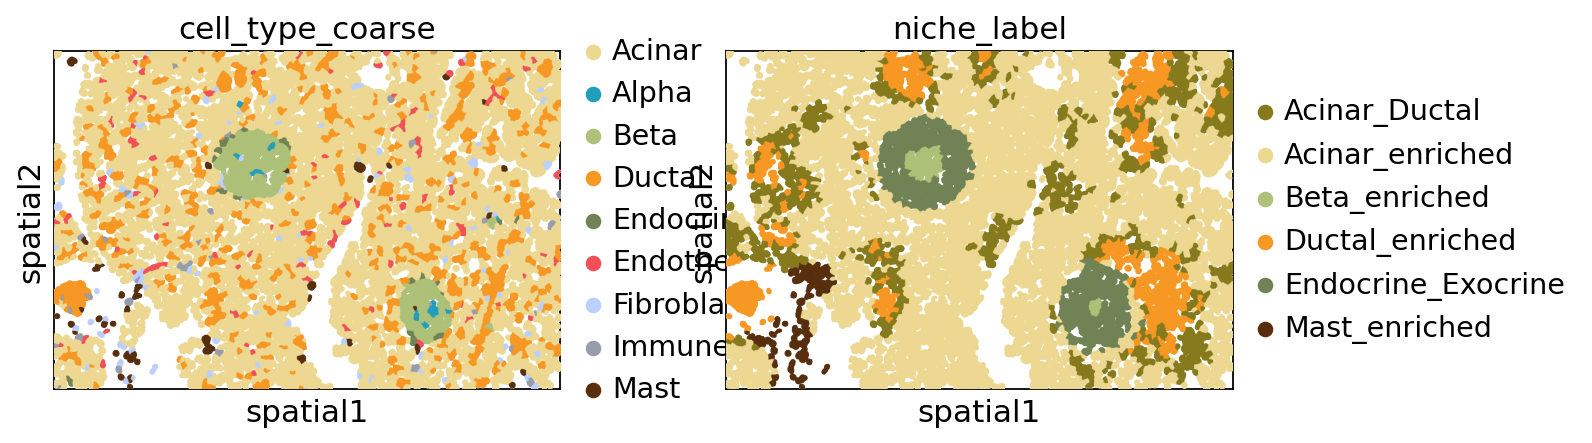

In [10]:
sq.pl.spatial_segment(adata,color=['cell_type_coarse','niche_label'],ncols=2,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

In [11]:
from matplotlib.pyplot import rc_context

In [ ]:
HORMONES = ['INS','GCG','SST']
#adata.uns['cell_type_coarse_colors'] = ['#00bbf9', '#a7c957', '#F4BA41', '#e63946', '#6c757d', '#ffcdb2','#fb8500']

In [ ]:
# Check expression of known markers to get intuition of the dataset
with rc_context({'figure.figsize': (10.5,7)}):
    sc.pl.embedding(
        adata,
        basis='spatial',
        color=HORMONES,
        vmin=0,
        vmax='p99',  
        sort_order=False,  
        frameon=False,
        cmap='RdYlBu_r', 
        size=150,ncols=3
    )

In [12]:
type(adata.X)

scipy.sparse._csr.csr_matrix

In [13]:
adata.X = adata.X.toarray()

1. Noise distribution of the dataset per cell type 
- NCEM requires gaussian distribution not negative binomial 
- Important not to overnormalized -> the 

Acinar
Alpha
Beta
Ductal
Endocrine
Endothelial
Fibroblasts
Immune
Mast


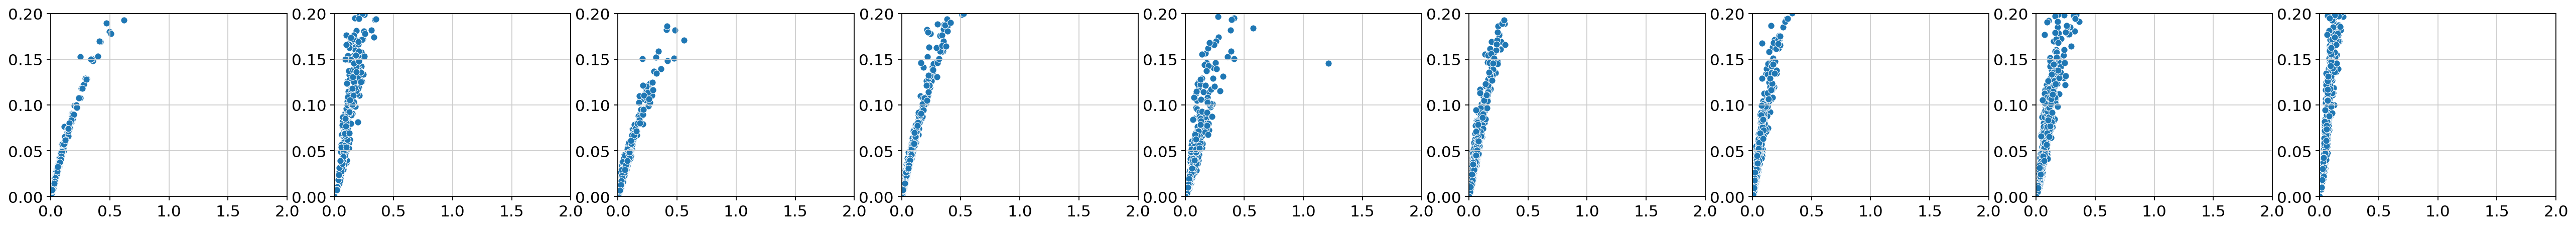

In [14]:
fig, ax = plt.subplots(1,len(np.unique(adata.obs['cell_type_coarse'])), figsize=(40,3))
for i, ct in enumerate(np.unique(adata.obs['cell_type_coarse'])):
    print(ct)
    mean = np.mean(adata[adata.obs['cell_type_coarse']==ct].X, axis=0)
    var = np.var(adata[adata.obs['cell_type_coarse']==ct].X, axis=0)
    g=sns.scatterplot(x=mean, y=var, ax=ax[i])
    g.set(ylim=(0, 0.2), xlim=(0,2))

In [15]:
adata.obs['cell_type_coarse'].cat.categories

Index(['Acinar', 'Alpha', 'Beta', 'Ductal', 'Endocrine', 'Endothelial',
       'Fibroblasts', 'Immune', 'Mast'],
      dtype='object')

### Pre-processing

In [16]:
adata.X.max()

4.3824596

In [17]:
adata.layers['counts'].max()

226

#### the data seems normalized
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
adata.X

In [18]:
# calculating node degree for several distances 
for rd in [0,35,50,110,180,500]:
    connectivities, _ = sq.gr.spatial_neighbors(
        adata, radius=rd, coord_type='generic', copy=True
    )
    print(np.mean(np.sum(connectivities, axis=0)))

0.0
0.15238525887406737
0.9509382771874293
8.533574496947773
23.224960434094506
166.51232195342527


In [19]:
sq.gr.spatial_neighbors(
    adata,
    n_neighs=50,
    coord_type="generic",
    delaunay=True,
    library_key='fov'
)

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_color_utils.py:27: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  target.uns[color_key] = source.uns[color_key]
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)


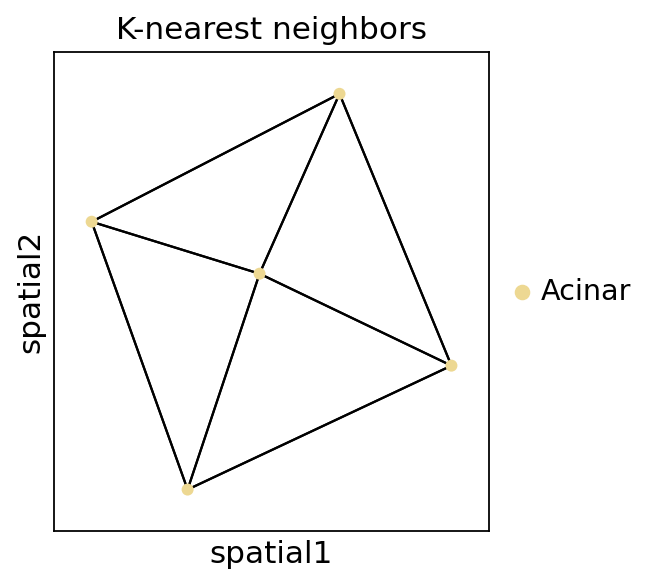

In [20]:
_, idx = adata.obsp["spatial_connectivities"][420, :].nonzero()
idx = np.append(idx, 420)
sq.pl.spatial_scatter(
    adata[idx,420],
    library_id = '12',
    color="cell_type_coarse",
    connectivity_key="spatial_connectivities",
    size=3,
    edges_width=1,
    edges_color="black",
    img=False,
    title="K-nearest neighbors"
)

### Neighbors enrichment analysis

In [21]:
sq.gr.nhood_enrichment(adata,cluster_key='cell_type_coarse')

100%|██████████| 1000/1000 [00:01<00:00, 736.69/s]


/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]


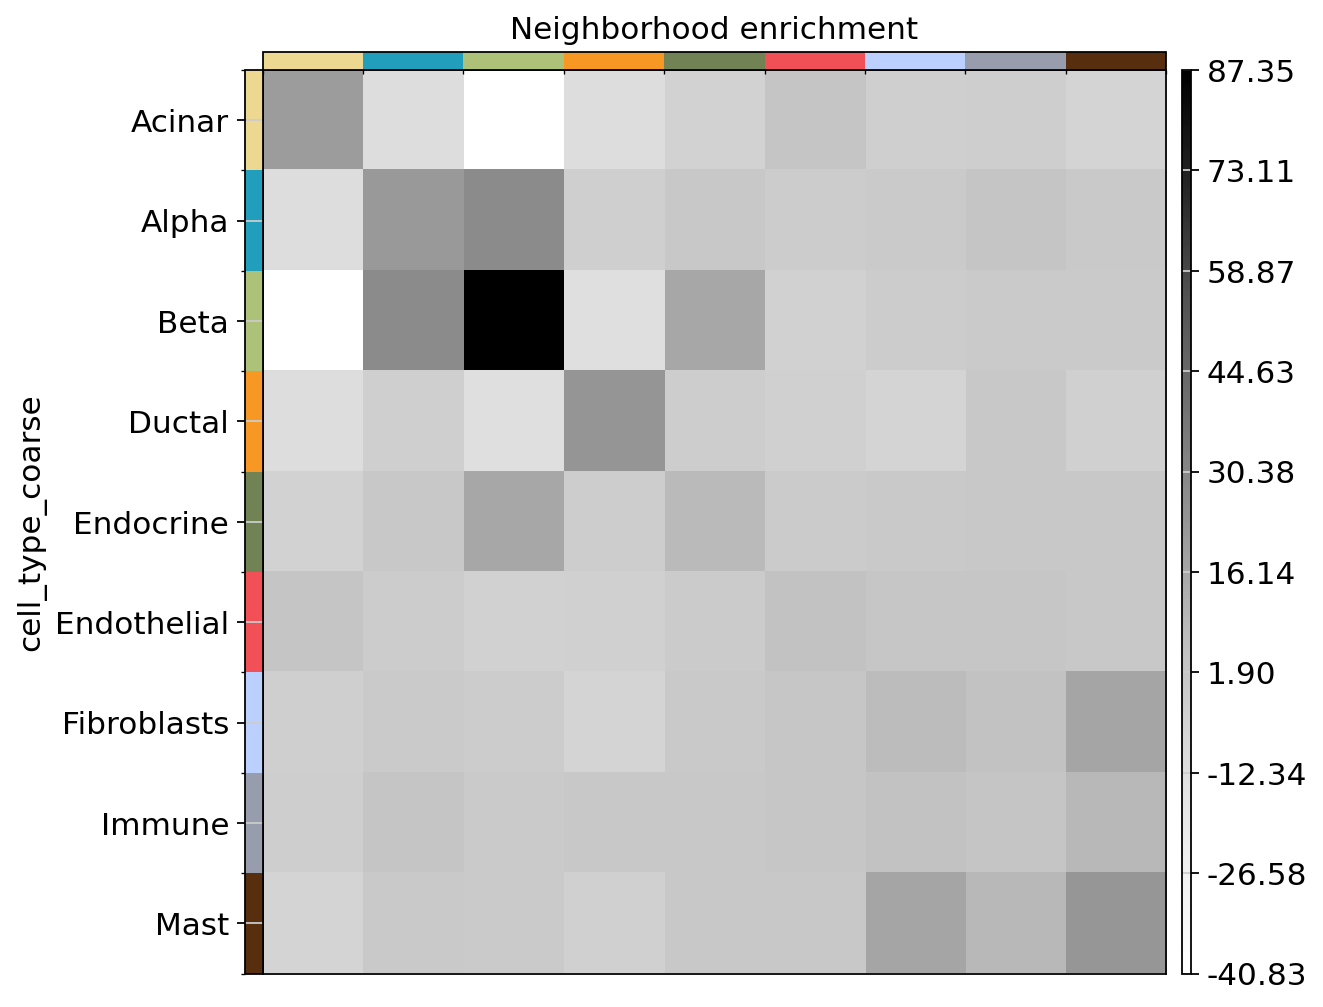

In [22]:
sq.pl.nhood_enrichment(adata, cluster_key='cell_type_coarse',cmap='Greys')

In [23]:
sq.gr.interaction_matrix(adata, cluster_key='cell_type_coarse',weights=True)

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/squidpy/pl/_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]


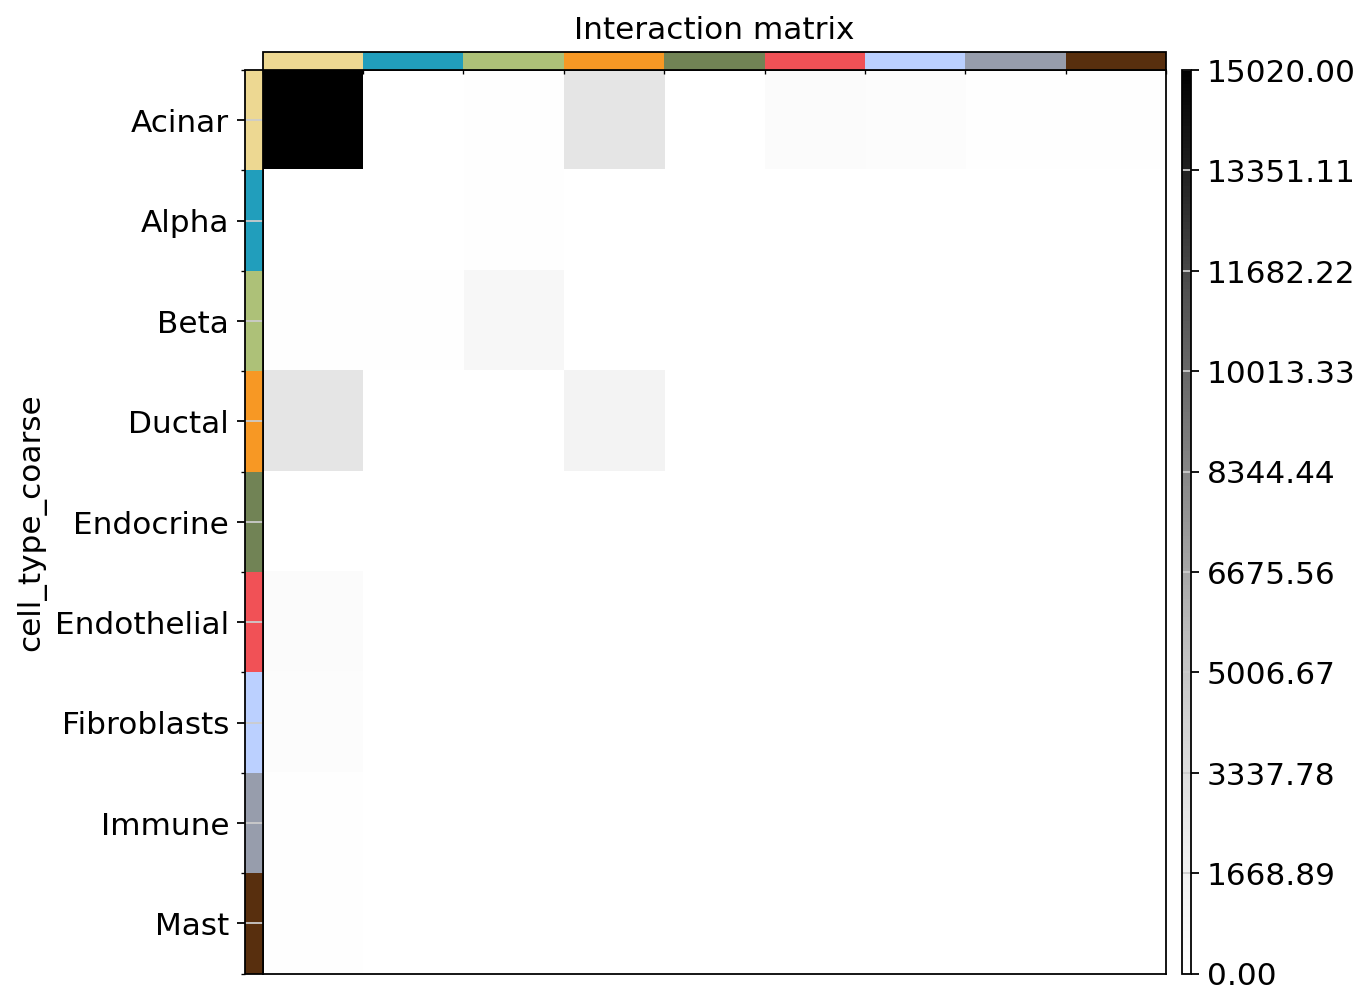

In [24]:
sq.pl.interaction_matrix(adata, cluster_key='cell_type_coarse',cmap='Greys')

### Compute Ripley’s statistics
The Ripley’s L function is a descriptive statistics generally used to determine whether points have a random, dispersed or clustered distribution pattern at certain scale.

In [ ]:
mode = "L"
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

sq.gr.ripley(adata, cluster_key="cell_type_coarse", mode=mode)
sq.pl.ripley(
    adata,
    cluster_key="cell_type_coarse",
    mode=mode,
    ax=ax[0],
)

sq.pl.spatial_segment(
    adata,
    shape="hex",
    color="cell_type_coarse",
    library_id="12",
    library_key="fov",
    seg_cell_id="cell_ID",
    img=False,
    size=60,
    ax=ax[1],
)

### Moran’s I score

The Moran’s I global spatial auto-correlation statistics evaluates whether features (i.e. genes) shows a pattern that is clustered, dispersed or random in the tissue are under consideration.

In [ ]:
#sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(
    adata,
    mode="moran",
    n_perms=100,
    n_jobs=1,
)
adata.uns["moranI"].head(10)

In [ ]:
adata.uns["moranI"].head(10).index.values

In [ ]:
adata.obs.cell_type_coarse.value_counts()

In [ ]:
sc.pl.matrixplot(adata, adata.uns["moranI"].head(10).index.values, groupby='cell_type_coarse', cmap='Greys')
#mp.add_totals().style(edge_color='black').show()

In [ ]:
sq.pl.spatial_segment(
    adata,
    library_id="10",
    seg_cell_id="cell_ID",
    library_key="fov",
    color=["GCG", "INS", "CPB1","SPINK1"],
    size=60,
    img=False,cmap="RdYlBu_r"
)

### Ligand receptor analysis

In [ ]:
sq.gr.ligrec(adata,cluster_key='cell_type_coarse',use_raw=False, alpha=0.005)

In [ ]:
sq.pl.ligrec(adata, cluster_key='cell_type_coarse',pvalue_threshold=0.0001,
             remove_nonsig_interactions=True, remove_empty_interactions=True,figsize = (10,10))

### NCEM

In [25]:
from ncem.tl.fit.glm import linear_ncem

In [ ]:
linear_ncem

In [26]:
adata = linear_ncem(adata=adata, key_type='niche_label', key_graph='spatial_connectivities')

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [27]:
adata.obs['niche_label'].cat.categories

Index(['Acinar_Ductal', 'Acinar_enriched', 'Beta_enriched', 'Ductal_enriched',
       'Endocrine_Exocrine', 'Mast_enriched'],
      dtype='object')

In [28]:
adata

AnnData object with n_obs × n_vars = 4423 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'niche_label'
    uns: 'cell_type_coarse_colors', 'spatial', 'spatial_neighbors', 'niche_label_colors', 'cell_type_coarse_nhood_enrichment', 'cell_type_coarse_interactions', 'ncem'
    obsm: 'spatial', 'spatial_fov', 'ncem_niche', 'ncem_dmat'
    varm: 'ncem_params', 'ncem_tested_params', 'ncem_pvals', 'ncem_fdr_pvals'
    layers: 'counts'
    obsp: 'spatial_conn

#### Exploring interesting interactions

In [29]:
adata.varm['ncem_params']

,index_Acinar_Ductal,index_Acinar_enriched,index_Beta_enriched,index_Ductal_enriched,index_Endocrine_Exocrine,index_Mast_enriched,index_Acinar_Ductal:neighbor_Acinar_Ductal,index_Acinar_enriched:neighbor_Acinar_Ductal,index_Beta_enriched:neighbor_Acinar_Ductal,index_Ductal_enriched:neighbor_Acinar_Ductal,...,index_Beta_enriched:neighbor_Endocrine_Exocrine,index_Ductal_enriched:neighbor_Endocrine_Exocrine,index_Endocrine_Exocrine:neighbor_Endocrine_Exocrine,index_Mast_enriched:neighbor_Endocrine_Exocrine,index_Acinar_Ductal:neighbor_Mast_enriched,index_Acinar_enriched:neighbor_Mast_enriched,index_Beta_enriched:neighbor_Mast_enriched,index_Ductal_enriched:neighbor_Mast_enriched,index_Endocrine_Exocrine:neighbor_Mast_enriched,index_Mast_enriched:neighbor_Mast_enriched
AATK,0.049342,0.006786,4.106579e-02,0.026049,0.350165,0.007470,-0.006747,-0.003429,1.143050e-15,0.008213,...,7.912460e-03,0.012579,-0.286608,0.0,0.013831,0.011406,0.0,-0.048985,0.0,0.007470
ABL1,-0.011731,-0.020138,5.797468e-02,0.000629,0.038650,0.026079,0.036602,0.007630,2.660631e-17,0.000328,...,-3.183979e-02,-0.005206,-0.008152,0.0,-0.027502,-0.036055,0.0,0.155021,0.0,0.026079
ABL2,0.060609,0.182191,8.585111e-03,0.199800,0.116160,0.053712,0.049032,-0.018267,1.404639e-15,-0.020181,...,3.200890e-02,0.017880,-0.037663,0.0,-0.038660,0.001130,0.0,-0.124430,0.0,0.053712
ACE,0.009451,0.029627,4.428482e-02,0.001688,0.031234,0.014524,-0.003609,0.003583,-1.601589e-16,-0.003210,...,-2.081742e-02,-0.029615,-0.006959,0.0,-0.012171,0.013794,0.0,-0.025099,0.0,0.014524
ACE2,0.103757,0.124374,1.100045e-02,0.000059,0.072135,0.012163,-0.069918,0.006837,-5.064519e-16,0.000886,...,-9.102059e-03,-0.028471,-0.018873,0.0,0.027636,-0.003510,0.0,-0.031608,0.0,0.012163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NegPrb19,0.056641,0.005883,1.541166e-02,-0.015960,0.272650,0.013477,-0.031273,0.000122,6.877694e-16,0.014777,...,-3.225512e-03,0.043059,-0.268328,0.0,-0.021170,-0.020097,0.0,-0.009605,0.0,0.013477
NegPrb20,0.057821,0.048389,3.682149e-02,-0.011279,0.289449,0.007085,-0.024711,-0.005310,4.729435e-16,0.006510,...,-5.664940e-02,0.009488,-0.268428,0.0,-0.037095,0.024989,0.0,-0.025483,0.0,0.007085
NegPrb21,0.028451,-0.003146,4.643662e-15,0.016866,0.280637,0.023776,-0.020311,0.002080,9.962646e-16,-0.020599,...,4.580939e-16,-0.026122,-0.269633,0.0,-0.012037,0.016872,0.0,-0.018864,0.0,0.023776
NegPrb22,0.002338,0.031566,-2.018885e-15,-0.006213,-0.095603,0.013427,0.024998,0.000447,-6.098399e-16,0.008089,...,3.409008e-16,-0.017547,0.113131,0.0,-0.023592,-0.028368,0.0,-0.021874,0.0,0.013427


In [30]:
#df = pd.DataFrame(np.sum(np.absolute(adata.varm['ncem_fdr_pvals']<0.05)))
df = pd.DataFrame(np.sum(np.absolute(adata.varm['ncem_params'])))
df_int = pd.DataFrame(columns=adata.obs['niche_label'].cat.categories, index=adata.obs['niche_label'].cat.categories,dtype=float)
for s in adata.obs['niche_label'].cat.categories:
    for r in adata.obs['niche_label'].cat.categories: 
        index_value = 'index_'+s+':neighbor_'+r
        df_int.at[s,r] = df.loc[index_value][0]
df_int

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


,Acinar_Ductal,Acinar_enriched,Beta_enriched,Ductal_enriched,Endocrine_Exocrine,Mast_enriched
Acinar_Ductal,2.634324e+01,1.186427e+01,9.595884e-14,1.046992e+01,41.259061,40.536677
Acinar_enriched,5.917246e+00,4.321193e+01,1.201180e-13,1.659724e+01,13.333329,22.786809
Beta_enriched,7.188473e-13,5.110857e-13,3.530572e+01,6.552180e-15,36.628127,0.000000
Ductal_enriched,1.760012e+01,1.815796e+01,4.649543e-14,4.831685e+01,41.820280,93.117565
Endocrine_Exocrine,5.264001e+01,3.680406e+01,3.117224e+01,5.230750e+01,81.662106,0.000000
Mast_enriched,5.189803e+01,3.817673e+01,1.552013e-13,5.826587e+01,0.000000,31.888648


In [31]:
import seaborn as sns

<Axes: >

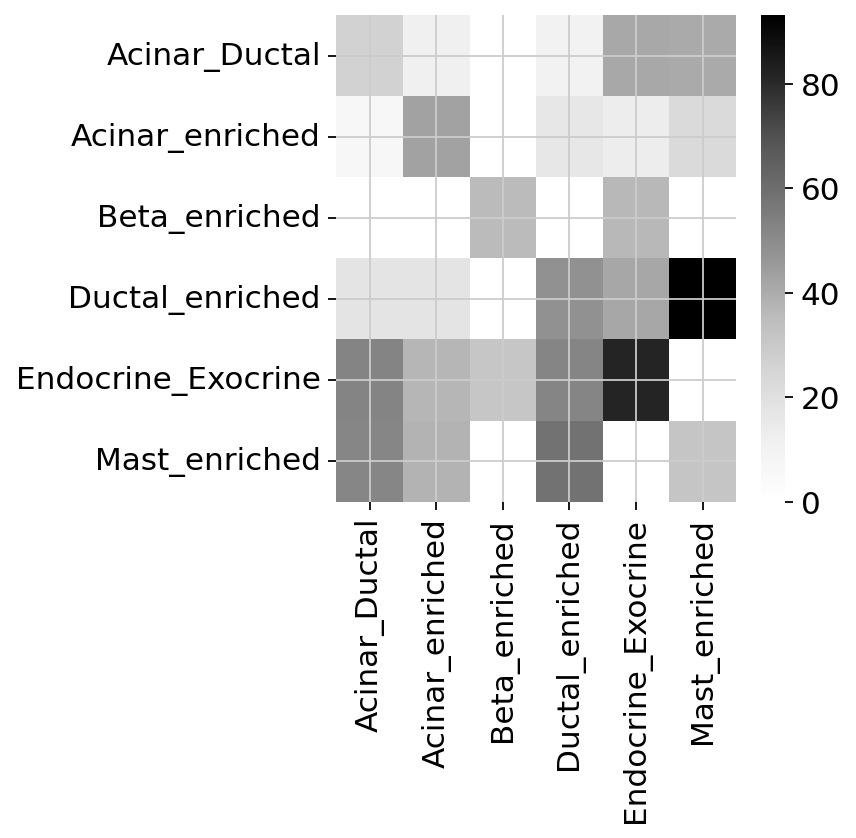

In [32]:
sns.heatmap(
            df_int,
            cmap="Greys",
        )

In [45]:
interactions = [
    #'index_Endocrine_Exocrine:neighbor_Endocrine_Exocrine',
    'index_Ductal_enriched:neighbor_Mast_enriched'
]

/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite va

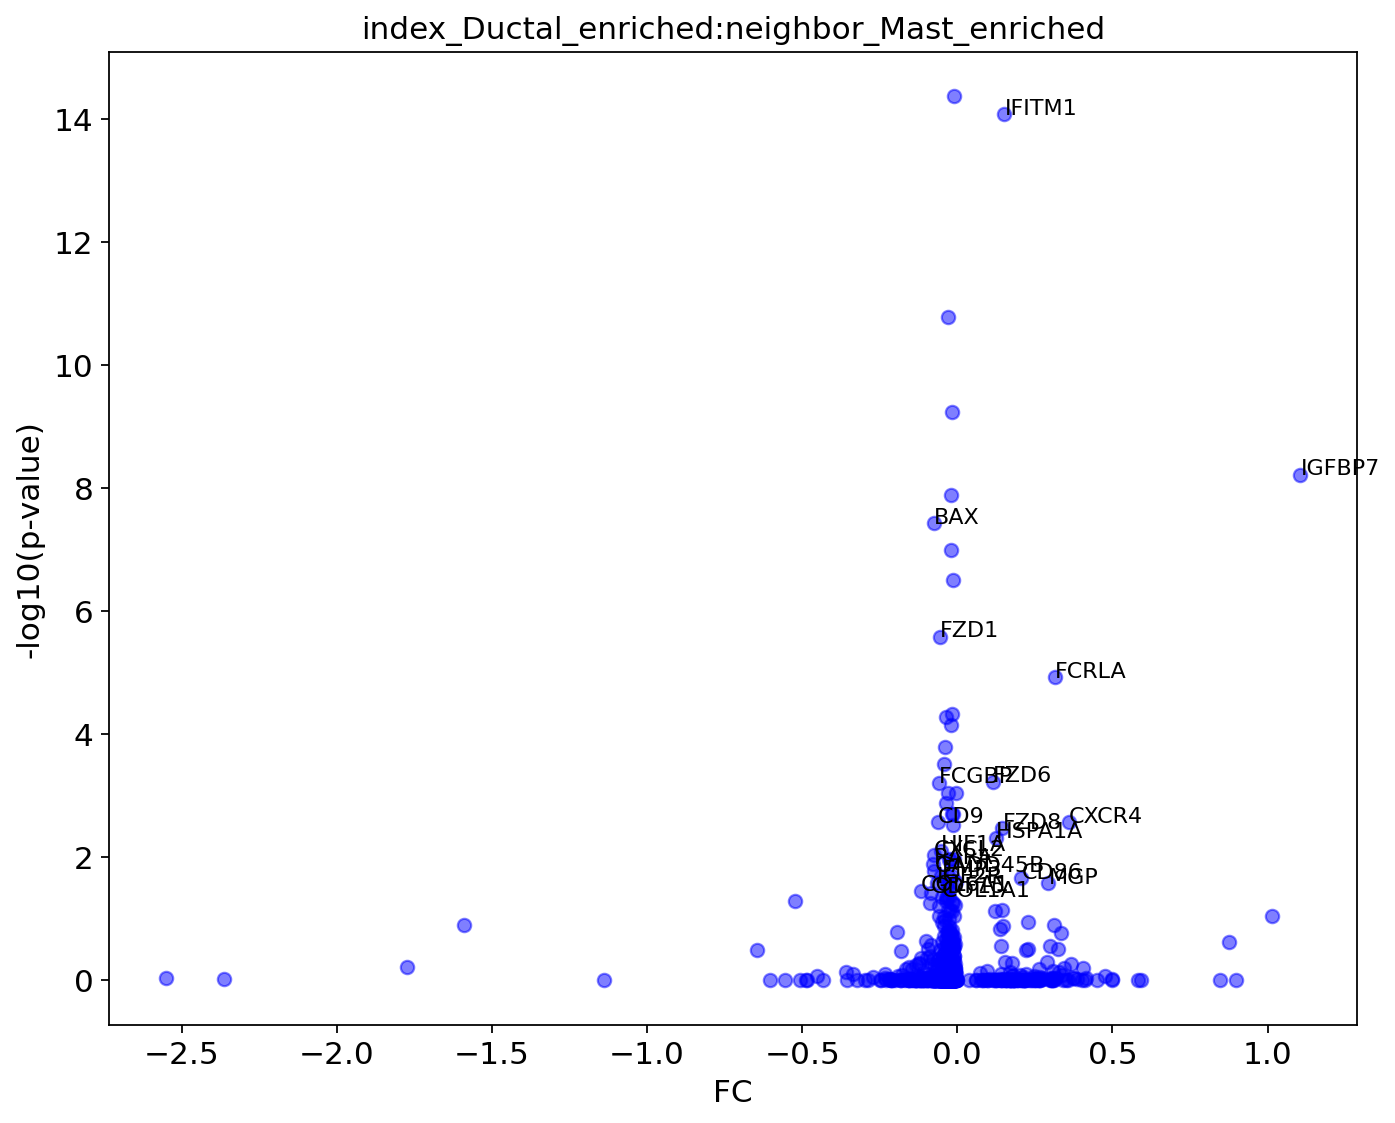

In [46]:
for c in interactions:
    data_df = {
        'log2FoldChange' : adata.varm['ncem_params'][c],
        'padj' : adata.varm['ncem_fdr_pvals'][c],
        'symbol' : np.array(adata.varm['ncem_fdr_pvals'].index)
    }
    
    df = pd.DataFrame(data_df)
    
    df['-log10(p_value)'] = -np.log10(df['padj'])
    

    plt.figure(figsize=(10, 8))
    plt.scatter(df['log2FoldChange'], df['-log10(p_value)'], color='blue', alpha=0.5)
    
    # Label the most significant points
    threshold_logFC = 0.05  # Adjust as needed
    threshold_p_value = 0.05  # Adjust as needed
    significant_points = df[(abs(df['log2FoldChange']) >= threshold_logFC) & (df['padj'] <= threshold_p_value)]
    for i, point in significant_points.iterrows():
        plt.text(point['log2FoldChange'], point['-log10(p_value)'], point['symbol'], fontsize=10)
        #volcano(df)
        
    # Add labels and title
    plt.xlabel('FC')
    plt.ylabel('-log10(p-value)')
    plt.title(c)
    
    # Show plot
    plt.grid(False)
    plt.show()

In [47]:
df

,log2FoldChange,padj,symbol,-log10(p_value)
AATK,-0.048985,9.895955e-01,AATK,0.004542
ABL1,0.155021,5.087730e-01,ABL1,0.293476
ABL2,-0.124430,5.195484e-01,ABL2,0.284374
ACE,-0.025099,1.000000e+00,ACE,-0.000000
ACE2,-0.031608,9.723830e-01,ACE2,0.012163
...,...,...,...,...
NegPrb19,-0.009605,1.073597e-02,NegPrb19,1.969159
NegPrb20,-0.025483,4.710921e-01,NegPrb20,0.326894
NegPrb21,-0.018864,1.000000e+00,NegPrb21,-0.000000
NegPrb22,-0.021874,1.013761e-07,NegPrb22,6.994064


In [48]:
#significant_points = df[(abs(df['log2FoldChange']) >= threshold_logFC) & (df['padj'] <= threshold_p_value)]
sp = significant_points.dropna().sort_values('-log10(p_value)', ascending=False)
# Replace infinite values with NaN
sp.replace([np.inf, -np.inf], np.nan, inplace=True)
sp.dropna(inplace=True)
sp

,log2FoldChange,padj,symbol,-log10(p_value)
IFITM1,0.151719,8.360833e-15,IFITM1,14.077750
IGFBP7,1.106104,6.038680e-09,IGFBP7,8.219058
BAX,-0.075079,3.676604e-08,BAX,7.434553
FZD1,-0.057001,2.573228e-06,FZD1,5.589522
FCRLA,0.314082,1.186658e-05,FCRLA,4.925675
FZD6,0.114426,5.944240e-04,FZD6,3.225904
FCGBP,-0.059719,6.098888e-04,FCGBP,3.214749
CD9,-0.061757,2.697689e-03,CD9,2.569008
CXCR4,0.359733,2.706040e-03,CXCR4,2.567666
FZD8,0.145635,3.368262e-03,FZD8,2.472594


/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()
/home/aih/sara.jimenez/miniconda3/envs/ncem/lib/python3.9/site-packages/scanpy/plotting/_baseplot_class.py:893: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  var_names_ordered = [self.var_names[x] for x in var_names_idx_ordered]


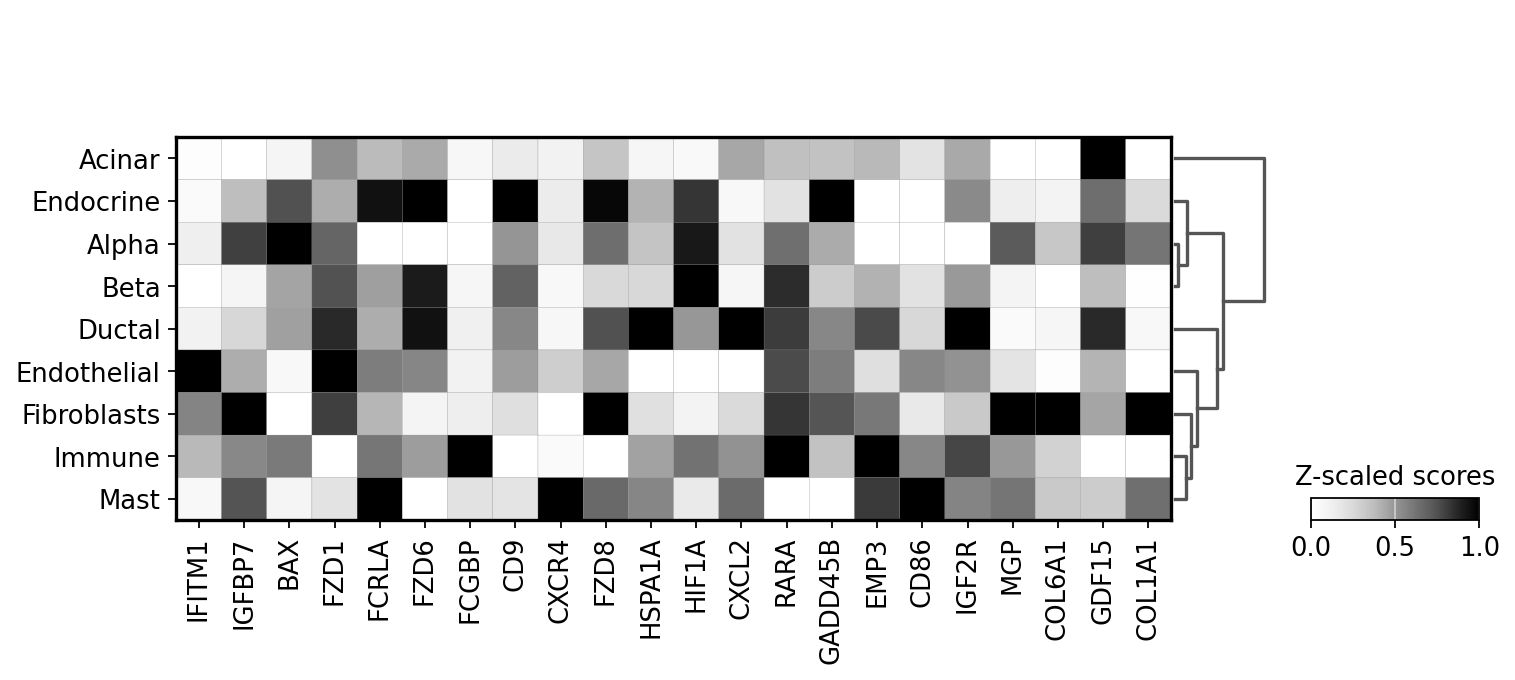

In [49]:
sc.pl.matrixplot(adata, sp['symbol'], 'cell_type_coarse', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='Greys')